In [1]:
import tqdm
import numpy as np
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

import ulsif

In [20]:
tmis = [-0.5 * np.log(1 - c**2) for c in np.arange(0, 1, 0.1)]

In [3]:
n = 300
cov = np.array([[1, 0.5], [0.5, 1]])
XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(n)
X, Y = np.split(XY, [1], axis=1)

In [4]:
sigmas = [1e-2, 5e-2, 0.1, 0.3, 0.5, 1, 2, 3, 5, 10]
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cv = ulsif.MutualInformationCV(sigmas=sigmas, lambdas=lambdas)
cv.fit(X, Y)

sigma: 0.010000, lambda: 0.000001, score: 311.438223
sigma: 0.010000, lambda: 0.000010, score: 310.838919
sigma: 0.010000, lambda: 0.000100, score: 304.875465
sigma: 0.010000, lambda: 0.001000, score: 248.054047
sigma: 0.010000, lambda: 0.010000, score: -132.117948
sigma: 0.010000, lambda: 0.100000, score: -757.303025
sigma: 0.100000, lambda: 0.100000, score: -792.040373
sigma: 0.300000, lambda: 0.010000, score: -840.624798
sigma: 0.500000, lambda: 0.010000, score: -851.876062
sigma: 1.000000, lambda: 0.010000, score: -865.250147


In [18]:
sigmas = [1e-2, 5e-2, 0.1, 0.3, 0.5, 1, 2, 5]
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

mis = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    cov = np.array([[1, c], [c, 1]])
    XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(n)
    X, Y = np.split(XY, [1], axis=1)
    mis += [ulsif.MutualInformationCV(sigmas=sigmas, lambdas=lambdas).fit(X, Y).mi]
#     mis += [ulsif.MutualInformation(sigma=cv.sigma_opt, lamb=cv.lambda_opt).fit(X, Y).mi]

  0%|          | 0/10 [00:00<?, ?it/s]

sigma: 0.010000, lambda: 0.000001, score: 272.922539
sigma: 0.010000, lambda: 0.000010, score: 272.781634
sigma: 0.010000, lambda: 0.000100, score: 271.374313
sigma: 0.010000, lambda: 0.001000, score: 257.472358
sigma: 0.010000, lambda: 0.010000, score: 133.821427
sigma: 0.010000, lambda: 0.100000, score: -393.489446
sigma: 0.050000, lambda: 0.100000, score: -652.978282
sigma: 0.100000, lambda: 0.100000, score: -682.337118
sigma: 0.300000, lambda: 0.010000, score: -748.404902
sigma: 0.500000, lambda: 0.010000, score: -753.212106
sigma: 2.000000, lambda: 0.001000, score: -763.976446
sigma: 5.000000, lambda: 0.000100, score: -768.309255


 10%|█         | 1/10 [00:17<02:36, 17.39s/it]

sigma: 0.010000, lambda: 0.000001, score: -425.759034
sigma: 0.010000, lambda: 0.000010, score: -425.763933
sigma: 0.010000, lambda: 0.000100, score: -425.813349
sigma: 0.010000, lambda: 0.001000, score: -426.348650
sigma: 0.010000, lambda: 0.010000, score: -434.681648
sigma: 0.010000, lambda: 0.100000, score: -539.312457
sigma: 0.050000, lambda: 0.100000, score: -583.718312
sigma: 0.100000, lambda: 0.010000, score: -584.405669
sigma: 0.100000, lambda: 0.100000, score: -616.382608
sigma: 0.300000, lambda: 0.001000, score: -675.712504
sigma: 0.300000, lambda: 0.010000, score: -684.128083
sigma: 0.500000, lambda: 0.001000, score: -710.689839
sigma: 1.000000, lambda: 0.000010, score: -715.871103
sigma: 1.000000, lambda: 0.000100, score: -741.332431
sigma: 2.000000, lambda: 0.000001, score: -741.497800
sigma: 2.000000, lambda: 0.000010, score: -748.509236
sigma: 5.000000, lambda: 0.000001, score: -762.477805


 20%|██        | 2/10 [00:33<02:16, 17.02s/it]

sigma: 0.010000, lambda: 0.000001, score: -566.315190
sigma: 0.010000, lambda: 0.000010, score: -566.328881
sigma: 0.010000, lambda: 0.000100, score: -566.464958
sigma: 0.010000, lambda: 0.001000, score: -567.750380
sigma: 0.010000, lambda: 0.010000, score: -577.196014
sigma: 0.010000, lambda: 0.100000, score: -617.920737
sigma: 0.100000, lambda: 0.010000, score: -672.756228
sigma: 0.300000, lambda: 0.000100, score: -683.991127
sigma: 0.300000, lambda: 0.001000, score: -719.406055
sigma: 0.300000, lambda: 0.010000, score: -730.870837
sigma: 0.500000, lambda: 0.000100, score: -733.947400
sigma: 0.500000, lambda: 0.001000, score: -752.712872
sigma: 1.000000, lambda: 0.000001, score: -758.731525
sigma: 1.000000, lambda: 0.000100, score: -759.369112
sigma: 1.000000, lambda: 0.001000, score: -767.533036
sigma: 2.000000, lambda: 0.000010, score: -772.479589
sigma: 2.000000, lambda: 0.000100, score: -781.255357
sigma: 5.000000, lambda: 0.000001, score: -793.583626
sigma: 5.000000, lambda: 0.0

 30%|███       | 3/10 [00:49<01:57, 16.79s/it]

sigma: 0.010000, lambda: 0.000001, score: -1243.826972


 40%|████      | 4/10 [01:05<01:39, 16.50s/it]

sigma: 0.010000, lambda: 0.000001, score: -998.405175


 50%|█████     | 5/10 [01:21<01:21, 16.29s/it]

sigma: 0.010000, lambda: 0.000001, score: -140.463701
sigma: 0.010000, lambda: 0.000010, score: -140.683046
sigma: 0.010000, lambda: 0.000100, score: -142.867628
sigma: 0.010000, lambda: 0.001000, score: -163.877208
sigma: 0.010000, lambda: 0.010000, score: -319.654700
sigma: 0.010000, lambda: 0.100000, score: -731.474512
sigma: 0.050000, lambda: 0.010000, score: -737.772698
sigma: 0.050000, lambda: 0.100000, score: -760.990960
sigma: 0.100000, lambda: 0.010000, score: -794.455045
sigma: 0.300000, lambda: 0.001000, score: -839.862071
sigma: 0.500000, lambda: 0.000100, score: -844.378371
sigma: 0.500000, lambda: 0.001000, score: -855.888968
sigma: 1.000000, lambda: 0.000010, score: -863.330865
sigma: 1.000000, lambda: 0.000100, score: -875.521938
sigma: 2.000000, lambda: 0.000001, score: -893.506030
sigma: 2.000000, lambda: 0.000010, score: -899.751553


 60%|██████    | 6/10 [01:37<01:05, 16.28s/it]

sigma: 0.010000, lambda: 0.000001, score: -1256.357301


 70%|███████   | 7/10 [01:53<00:48, 16.17s/it]

sigma: 0.010000, lambda: 0.000001, score: -1260.026896


/home/ytakashina/workspace/density_ratio/ulsif.py:95: RuntimeWarning: invalid value encountered in log
  theta = np.linalg.solve(H + lamb * np.eye(b), h)


sigma: 0.300000, lambda: 0.000100, score: -1268.617119
sigma: 0.500000, lambda: 0.000001, score: -1272.268608
sigma: 0.500000, lambda: 0.000010, score: -1295.815075
sigma: 1.000000, lambda: 0.000001, score: -1338.813148
sigma: 1.000000, lambda: 0.000010, score: -1339.155725
sigma: 2.000000, lambda: 0.000001, score: -1340.905289


 80%|████████  | 8/10 [02:09<00:32, 16.10s/it]

sigma: 0.010000, lambda: 0.000001, score: 4313.871756
sigma: 0.010000, lambda: 0.000010, score: 4301.923801
sigma: 0.010000, lambda: 0.000100, score: 4184.573381
sigma: 0.010000, lambda: 0.001000, score: 3193.166033
sigma: 0.010000, lambda: 0.010000, score: -93.097911
sigma: 0.010000, lambda: 0.100000, score: -1213.718235
sigma: 0.050000, lambda: 0.010000, score: -1461.813369
sigma: 0.100000, lambda: 0.001000, score: -1563.684270
sigma: 0.100000, lambda: 0.010000, score: -1600.758016
sigma: 0.300000, lambda: 0.000100, score: -1608.608684
sigma: 0.300000, lambda: 0.001000, score: -1801.133105


 90%|█████████ | 9/10 [02:25<00:16, 16.08s/it]

sigma: 0.010000, lambda: 0.000001, score: -2667.871079
sigma: 0.300000, lambda: 0.000001, score: -2717.989862


100%|██████████| 10/10 [02:41<00:00, 16.02s/it]


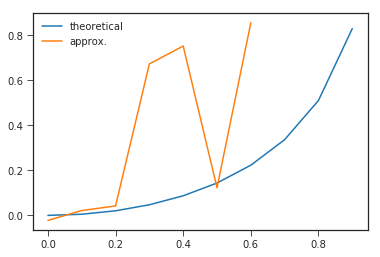

In [21]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), mis, label='approx.')
plt.legend()